In [2]:
import numpy as np
import pandas as pd 
import plotly.express as px
import plotly.graph_objects as go
from scipy.signal import detrend
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit

In [3]:
df = pd.read_csv(r'task1\ts.csv')
print(df.shape)
df = df.rename(columns={'Unnamed: 0' : 'date', '0': 'num'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.head()

(2699, 2)


,date,num
0,2011-07-13,1.649925e+06
1,2011-07-14,1.439200e+06
2,2011-07-15,2.377505e+06
3,2011-07-16,4.043366e+06
4,2011-07-17,2.972691e+06


In [4]:
def calculate_confidence_intervals(window_size, original_series, rolling_series, scale=1.96):
    mae = mean_absolute_error(original_series[window_size:], rolling_series[window_size:])
    deviation = np.std(original_series[window_size:] - rolling_series[window_size:])
    lower_bound = rolling_series - (mae + scale * deviation)
    upper_bound = rolling_series + (mae + scale * deviation)
    return lower_bound, upper_bound

In [5]:
rolling_mean_5 = df['num'].rolling(window=5).mean()
rolling_mean_30 = df['num'].rolling(window=30).mean()

In [6]:
lower_bound, upper_bound = calculate_confidence_intervals(30, df.num, rolling_mean_30)

In [7]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['date'], y=df['num'], name='Original data'))
fig.add_trace(go.Scatter(x=df['date'], y=rolling_mean_5, name='Moving average with 5-day window'))
fig.add_trace(go.Scatter(x=df['date'], y=rolling_mean_30, name='Moving average with 30-day window'))
fig.add_trace(go.Scatter(x=df['date'], y=lower_bound, name='Lower bound of confidence interval'))
fig.add_trace(go.Scatter(x=df['date'], y=upper_bound, name='Upper bound of confidence interval'))

fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)
fig.show()

In [8]:
detrended = detrend(df['num'].values)
result_mul = seasonal_decompose(df['num'], model='additive', period=30)
deseasoned = df['num'].values - result_mul.trend
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['date'], y=detrended, name='Detrendeed time series data'))
fig.add_trace(go.Scatter(x=df['date'], y=deseasoned, name='Decomposed seasonally time series data'))

fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)
fig.show()

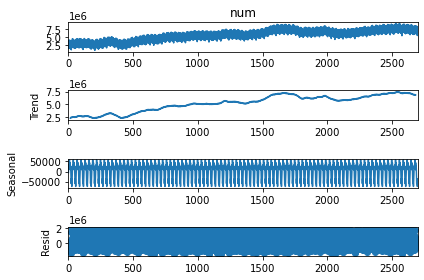

In [9]:
result_mul.plot()
pyplot.show()

In [10]:
adf = adfuller(df["num"])
print("1. ADF : ",adf[0])
print("2. P-Value : ", adf[1])

1. ADF :  -1.925588681420446
2. P-Value :  0.32012077532438854


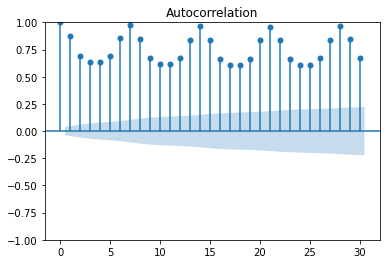

In [11]:
plot_acf(df['num'], lags=30)
pyplot.show()

C:\Users\dmytro.hlushenkov\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



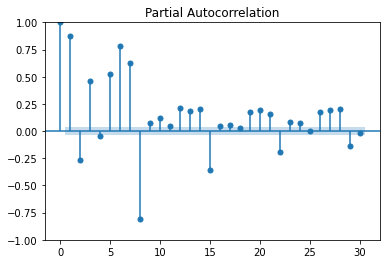

In [12]:
plot_pacf(df['num'], lags=30)
pyplot.show()

In [13]:
train_size = int(len(df.num) * 0.8)
train, test = df.num[:train_size], df.num[train_size:]

In [14]:
train.shape, test.shape

((2159,), (540,))

In [22]:
sarimax = SARIMAX(train, order=(2, 1, 6),seasonal_order=(1,1,2,7),enforce_stationarity=False,enforce_invertibility=False)
history = sarimax.fit()
forecasts = history.forecast(steps=len(test))

In [23]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.loc[train_size:]['date'], y=test, name='Original data'))
fig.add_trace(go.Scatter(x=df.loc[train_size:]['date'], y=forecasts, name='forecast'))

fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)
fig.show()